# Do it again, in Python

First, lets do exactly the same thing as in our "Get started" guide, but using the Python API.

In [1]:
import sys

In [2]:
import lincs

In [3]:
# @todo(Feature, v1.1) Make sure all the API can be called with arguments passed by name
problem = lincs.generate_classification_problem(4, 3, 40)

# @todo(Feature, v1.1) Provide __repr__ and __str__ where applicable
problem.dump(sys.stdout)

kind: classification-problem
format_version: 1
criteria:
  - name: Criterion 1
    value_type: real
    preference_direction: increasing
    min_value: 0
    max_value: 1
  - name: Criterion 2
    value_type: real
    preference_direction: increasing
    min_value: 0
    max_value: 1
  - name: Criterion 3
    value_type: real
    preference_direction: increasing
    min_value: 0
    max_value: 1
  - name: Criterion 4
    value_type: real
    preference_direction: increasing
    min_value: 0
    max_value: 1
ordered_categories:
  - name: Worst category
  - name: Intermediate category 1
  - name: Best category


In [4]:
import lincs.description

In [5]:
print("\n".join(lincs.description.describe_classification_problem(problem)))

This a classification problem into 3 ordered categories named "Worst category", "Intermediate category 1" and "Best category".
The best category is "Best category" and the worst category is "Worst category".
There are 4 classification criteria (in no particular order).
Criterion "Criterion 1" takes real values between 0.0 and 1.0 included.
Higher values of "Criterion 1" are known to be better.
Criterion "Criterion 2" takes real values between 0.0 and 1.0 included.
Higher values of "Criterion 2" are known to be better.
Criterion "Criterion 3" takes real values between 0.0 and 1.0 included.
Higher values of "Criterion 3" are known to be better.
Criterion "Criterion 4" takes real values between 0.0 and 1.0 included.
Higher values of "Criterion 4" are known to be better.


In [6]:
model = lincs.generate_mrsort_classification_model(problem, 41)

model.dump(problem, sys.stdout)

kind: ncs-classification-model
format_version: 1
accepted_values:
  - kind: thresholds
    thresholds: [0.255905151, 0.676961303]
  - kind: thresholds
    thresholds: [0.0551739037, 0.324553937]
  - kind: thresholds
    thresholds: [0.162252158, 0.673279881]
  - kind: thresholds
    thresholds: [0.0526000932, 0.598555863]
sufficient_coalitions:
  - &coalitions
    kind: weights
    criterion_weights: [0.147771254, 0.618687689, 0.406786472, 0.0960085914]
  - *coalitions


In [7]:
import matplotlib.pyplot as plt

import lincs.visualization

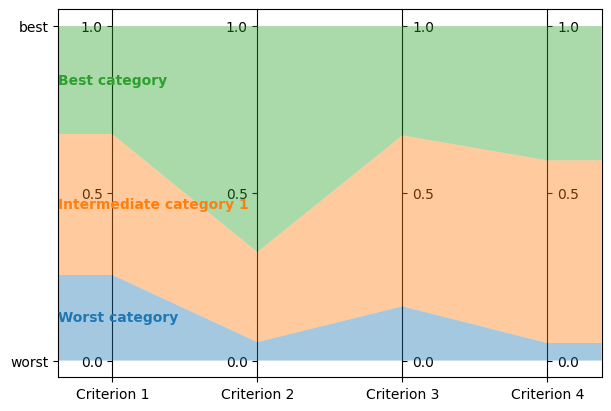

In [8]:
axes = plt.subplots(1, 1, figsize=(6, 4), layout="constrained")[1]
lincs.visualization.visualize_classification_model(problem, model, [], axes)

In [9]:
print("\n".join(lincs.description.describe_classification_model(problem, model)))

This is a MR-Sort (a.k.a. 1-Uc-NCS) model: an NCS model where the sufficient coalitions are specified using the same criterion weights for all boundaries.
The weights associated to each criterion are:
  - Criterion "Criterion 1": 0.15
  - Criterion "Criterion 2": 0.62
  - Criterion "Criterion 3": 0.41
  - Criterion "Criterion 4": 0.10
To get into an upper category, an alternative must be better than the following profiles on a set of criteria whose weights add up to at least 1:
  - For category "Intermediate category 1": at least 0.26 on criterion "Criterion 1", at least 0.06 on criterion "Criterion 2", at least 0.16 on criterion "Criterion 3", and at least 0.05 on criterion "Criterion 4"
  - For category "Best category": at least 0.68 on criterion "Criterion 1", at least 0.32 on criterion "Criterion 2", at least 0.67 on criterion "Criterion 3", and at least 0.60 on criterion "Criterion 4"


In [10]:
learning_set = lincs.generate_classified_alternatives(problem, model, 1000, 42)

for alt in learning_set.alternatives[:5]:
    print(f"{alt.name}: {[perf.real_value for perf in alt.profile]} -> {problem.ordered_categories[alt.category_index].name}")

Alternative 1: [0.3745401203632355, 0.7965430021286011, 0.9507142901420593, 0.18343478441238403] -> Best category
Alternative 2: [0.7319939136505127, 0.7796909809112549, 0.5986585021018982, 0.5968501567840576] -> Intermediate category 1
Alternative 3: [0.15601864457130432, 0.445832759141922, 0.15599451959133148, 0.09997492283582687] -> Worst category
Alternative 4: [0.058083612471818924, 0.4592489004135132, 0.8661761283874512, 0.33370861411094666] -> Best category
Alternative 5: [0.6011149883270264, 0.1428668200969696, 0.7080726027488708, 0.6508885025978088] -> Intermediate category 1


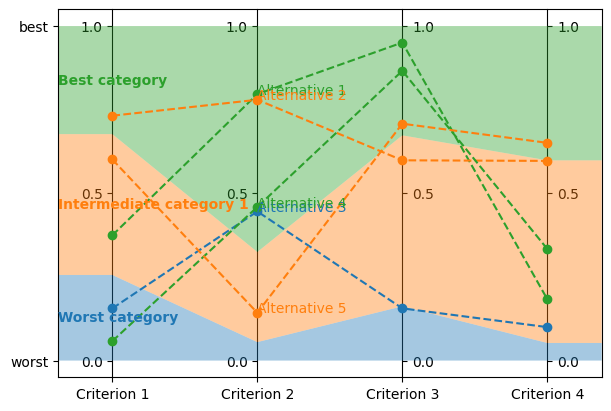

In [11]:
axes = plt.subplots(1, 1, figsize=(6, 4), layout="constrained")[1]
lincs.visualization.visualize_classification_model(problem, model, learning_set.alternatives[:5], axes)

In [12]:
# @todo(Feature, v1.1) Support using temporary strategies (i.e. passing 'lincs.OptimizeWeightsUsingGlop(learning_data)' directly to 'lincs.LearnMrsortByWeightsProfilesBreed' without capturing it in a variable)
learning_data = lincs.LearnMrsortByWeightsProfilesBreed.LearningData(problem, learning_set, 9, 43)
profiles_initialization_strategy = lincs.InitializeProfilesForProbabilisticMaximalDiscriminationPowerPerCriterion(learning_data)
weights_optimization_strategy = lincs.OptimizeWeightsUsingGlop(learning_data)
profiles_improvement_strategy = lincs.ImproveProfilesWithAccuracyHeuristicOnCpu(learning_data)
breeding_strategy = lincs.ReinitializeLeastAccurate(learning_data, profiles_initialization_strategy, 4)
termination_strategy = lincs.TerminateAtAccuracy(learning_data, len(learning_set.alternatives))

learning = lincs.LearnMrsortByWeightsProfilesBreed(
    learning_data,
    profiles_initialization_strategy,
    weights_optimization_strategy,
    profiles_improvement_strategy,
    breeding_strategy,
    termination_strategy,
)

learned_model = learning.perform()
learned_model.dump(problem, sys.stdout)

kind: ncs-classification-model
format_version: 1
accepted_values:
  - kind: thresholds
    thresholds: [0.339874953, 0.421424538]
  - kind: thresholds
    thresholds: [0.0556534864, 0.326433569]
  - kind: thresholds
    thresholds: [0.162616938, 0.67343241]
  - kind: thresholds
    thresholds: [0.0878681168, 0.252649099]
sufficient_coalitions:
  - &coalitions
    kind: weights
    criterion_weights: [0, 1.01327896e-06, 0.999998987, 0]
  - *coalitions


In [13]:
testing_set = lincs.generate_classified_alternatives(problem, model, 3000, 44)
classification_result = lincs.classify_alternatives(problem, learned_model, testing_set)
classification_result.changed, classification_result.unchanged

(4, 2996)

# Do more, with the Python API

## Create classification problem and model

You don't have to use our pseudo-random generation functions; you can create `Problem` and `Model` instances yourself:

In [14]:
# @todo(Feature, v1.1) Rename to 'ClassificationProblem'? And everything to 'ClassificationXxx'? Or namespace into 'lincs.classification'?
problem = lincs.Problem(
    [
        lincs.Criterion("Physics grade", lincs.Criterion.IntegerValues(lincs.Criterion.PreferenceDirection.increasing, 0, 100)),
        lincs.Criterion("Literature grade", lincs.Criterion.EnumeratedValues(["f", "e", "d", "c", "b", "a"])),
    ],
    [lincs.Category("Failed"), lincs.Category("Passed"), lincs.Category("Congratulations")],
)

problem.dump(sys.stdout)

kind: classification-problem
format_version: 1
criteria:
  - name: Physics grade
    value_type: integer
    preference_direction: increasing
    min_value: 0
    max_value: 100
  - name: Literature grade
    value_type: enumerated
    ordered_values: [f, e, d, c, b, a]
ordered_categories:
  - name: Failed
  - name: Passed
  - name: Congratulations


You can access all their attributes in code as well:

In [15]:
criterion = problem.criteria[0]

In [16]:
criterion.name

'Physics grade'

In [17]:
criterion.value_type, criterion.is_real, criterion.is_integer, criterion.is_enumerated

(liblincs.ValueType.integer, False, True, False)

In [18]:
values = criterion.integer_values

In [19]:
values.preference_direction, values.is_increasing, values.is_decreasing

(liblincs.PreferenceDirection.isotone, True, False)

In [20]:
values.min_value, values.max_value

(0, 100)

In [21]:
criterion = problem.criteria[1]

In [22]:
criterion.name

'Literature grade'

In [23]:
criterion.value_type, criterion.is_real, criterion.is_integer, criterion.is_enumerated

(liblincs.ValueType.enumerated, False, False, True)

In [24]:
values = criterion.enumerated_values

In [25]:
list(values.ordered_values)

['f', 'e', 'd', 'c', 'b', 'a']

In [26]:
values.get_value_rank("a")

5

In [27]:
model = lincs.Model(
    problem,
    [lincs.AcceptedValues(lincs.AcceptedValues.IntegerThresholds([50, 80])), lincs.AcceptedValues(lincs.AcceptedValues.EnumeratedThresholds(["c", "a"]))],
    [lincs.SufficientCoalitions(lincs.SufficientCoalitions.Weights([0.5, 0.5]))],
)

model.dump(problem, sys.stdout)

kind: ncs-classification-model
format_version: 1
accepted_values:
  - kind: thresholds
    thresholds: [50, 80]
  - kind: thresholds
    thresholds: [c, a]
sufficient_coalitions:
  - kind: weights
    criterion_weights: [0.5, 0.5]


In [28]:
accepted = model.accepted_values[0]

In [29]:
accepted.value_type, accepted.is_real, accepted.is_integer, accepted.is_enumerated

(liblincs.ValueType.integer, False, True, False)

In [30]:
accepted.kind, accepted.is_thresholds

(liblincs.Kind.thresholds, True)

In [31]:
list(accepted.integer_thresholds.thresholds)

[50, 80]

In [32]:
accepted = model.accepted_values[1]

In [33]:
accepted.value_type, accepted.is_real, accepted.is_integer, accepted.is_enumerated

(liblincs.ValueType.enumerated, False, False, True)

In [34]:
accepted.kind, accepted.is_thresholds

(liblincs.Kind.thresholds, True)

In [35]:
list(accepted.enumerated_thresholds.thresholds)

['c', 'a']

In [36]:
sufficient = model.sufficient_coalitions[0]

In [37]:
sufficient.kind, sufficient.is_weights, sufficient.is_roots

(liblincs.Kind.weights, True, False)

In [38]:
list(sufficient.weights.criterion_weights)

[0.5, 0.5]